In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import butter, lfilter
import scipy.signal

In [2]:
def generateChirp(start, end, sr, dur, samples = None):
    '''
    Generates a chirp signal

    Parameters:
    start (float): start frequency of the chirp
    end (float): end frequency of the chirp
    sr (num): sampling rate
    dur (num):  time duration of tone
    '''
    if samples is None:
        samples = int(sr * dur)
    time = np.linspace(0, dur, samples, False)

    linear_chirp = librosa.chirp(fmin=start, fmax=end, sr = sr, length = samples, duration=dur, linear=True)  
    
    return linear_chirp

In [3]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

In [4]:
def plot_spectogram(signal, sr, n_fft = 128, title = "Spectrogram", hop_length = None, win_length = None, ax = None):
    '''
    Displays a spectrogram (Frequency vs Time) for a signal

    Parameters:
    signal (np.array): the signal
    n_fft (num): length of the windowed signal. 
       Default is 128
    title (str): title of plot. Default is "Spectrogram".
    hop_length (int): number of audio samples between adjacent STFT columns. 
        If hop_length is not given then its value is taken as int(n_fft / 4)
    win_length (int <= n_fft): Each frame of audio is windowed by window of this length 
    ax(matplotlib.axes.Axes): The target axes instance for the plot.

    '''
    if hop_length is None:
        hop_length = int(n_fft / 4)
    
    stft = librosa.stft(y=signal, n_fft = n_fft, hop_length = hop_length, win_length = win_length)
    spectrogram = np.abs(stft)
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    
    if hop_length is None:
        hop_length = int(n_fft / 4)  # You can adjust the hop length calculation as needed
    frame_times = librosa.frames_to_time(np.arange(spectrogram.shape[1]), sr=sr, hop_length=hop_length)

    #plt.figure(figsize=(10, 6))
    im = librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='linear',x_coords=frame_times, ax=ax)
    #print(sr)
    #print(frame_times[len(frame_times)-1])
    
    #plt.ylim(17000,20000)
    
    plt.colorbar(im, ax=ax, format='%+2.0f dB')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)

    return im

In [5]:
def signal_info(signal, sample_rate):
    '''
    Displays sampling rate, time duration and number of samples in the signal
    
    Parameters:
    signal (np.array): the signal
    sample_rate (num): sampling rate
    '''
    duration = len(signal)/ sample_rate
    n_samples = int(duration * sample_rate)
    #time = np.arange(0, n_samples) / sample_rate

    print("Sampling Rate:", sample_rate)
    print("Signal time duration: ", duration)
    print("Number of samples: ", n_samples)

In [6]:
sampling_rate = 48000
dur = 0.01075
no_of_reps = 2813

distance = 1
v_sound =  343 
delay_duration = round((2*distance)/343, 4)

print("Delay duration: ", delay_duration)

Delay duration:  0.0058


##### **Ideal Transmitted Signal**

In [7]:
chirp = generateChirp(18000,20000, sampling_rate, dur,samples=512)

print("Chirp: ")
signal_info(chirp, sampling_rate)

Chirp: 
Sampling Rate: 48000
Signal time duration:  0.010666666666666666
Number of samples:  512


In [8]:
transmitted = np.tile(chirp, no_of_reps) # repeated chirp signal 
transmitted = transmitted[:sampling_rate *30]
sf.write('transmitted_30s.wav', transmitted, sampling_rate) 

print("Transmitted Signal: ")
signal_info(transmitted, sampling_rate)

Transmitted Signal: 
Sampling Rate: 48000
Signal time duration:  30.0
Number of samples:  1440000


In [9]:
F_transmitted, A_transmitted = compute_fft(transmitted, sampling_rate)

print("Resolution: ", 24000/len(F_transmitted))

all_F_transmitted = [F_transmitted[np.where(A_transmitted == np.sort(A_transmitted)[::-1][i])] for i in range(10)]
print("Transmitted Signal frequencies: ")
all_F_transmitted

Resolution:  0.03333333333333333
Transmitted Signal frequencies: 


[array([18375.]),
 array([19687.5]),
 array([19312.5]),
 array([18750.]),
 array([18937.5]),
 array([19125.]),
 array([19500.]),
 array([18562.5]),
 array([18187.5]),
 array([19875.])]

##### **Ideal Received Signal**

In [10]:
silence = np.zeros(int(sampling_rate * delay_duration))
signal_info(silence, sampling_rate)
chirp.shape[0]

Sampling Rate: 48000
Signal time duration:  0.005791666666666666
Number of samples:  278


512

In [11]:
delayed_signal = np.concatenate((silence, chirp))
print(delayed_signal.shape[0])
print("Delayed chirp: ")
signal_info(delayed_signal, sampling_rate)


received_chirp = np.tile(delayed_signal, 1823)
received_chirp = received_chirp[:sampling_rate *30]
print(received_chirp.shape[0])
print("\nReceived Chirp: ")
signal_info(received_chirp, sampling_rate)

#sf.write('received_chirp.wav', received_chirp, sampling_rate)

790
Delayed chirp: 
Sampling Rate: 48000
Signal time duration:  0.016458333333333332
Number of samples:  789
1440000

Received Chirp: 
Sampling Rate: 48000
Signal time duration:  30.0
Number of samples:  1440000


In [12]:
F_received, A_received = compute_fft(received_chirp, sampling_rate)

print("Resolution: ", 24000/len(F_received))

all_F_rep = [F_received[np.where(A_received == np.sort(A_received)[::-1][i])] for i in range(10)]
print("Received Chirp frequencies: ")
all_F_rep

Resolution:  0.03333333333333333
Received Chirp frequencies: 


[array([18349.36666667]),
 array([18410.13333333]),
 array([18896.2]),
 array([19260.76666667]),
 array([19746.83333333]),
 array([18713.93333333]),
 array([19564.56666667]),
 array([19686.06666667]),
 array([18956.96666667]),
 array([18288.6])]

##### **Ideal Transmitted and Received Signal Spectrum and Spectrogram**

Text(0.5, 1.0, 'Ideal Received Signal (Without Tone) Spectrogram')

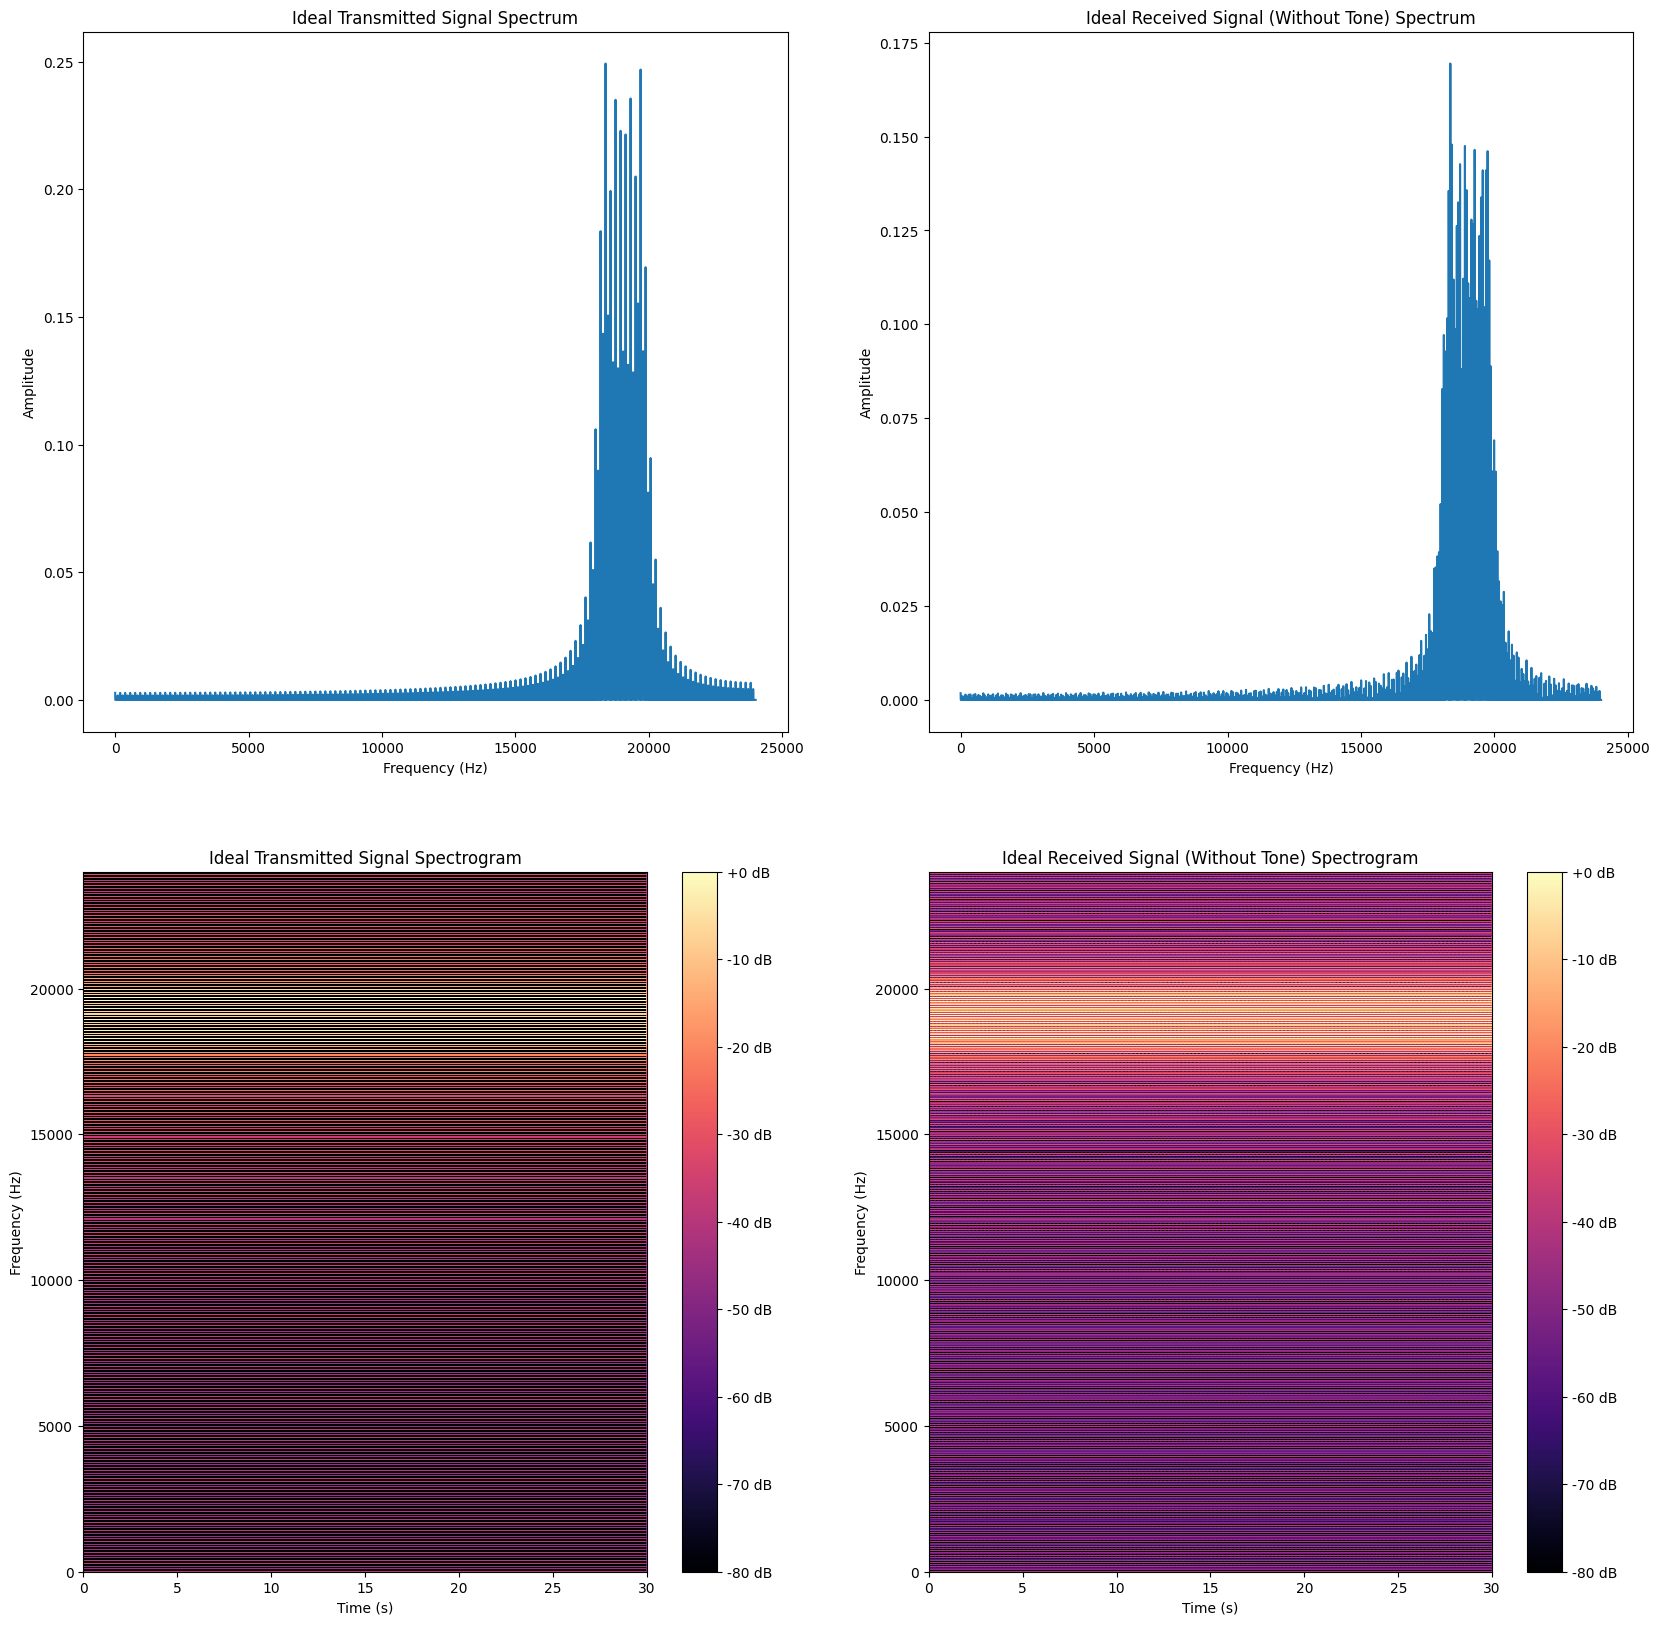

In [13]:
fig1, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (20,20))

ax1.plot(F_transmitted, A_transmitted)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Ideal Transmitted Signal Spectrum')

ax2.plot(F_received, A_received)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Ideal Received Signal (Without Tone) Spectrum')

plot_spectogram(transmitted, sampling_rate, n_fft= 4096, ax=ax3)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')
ax3.set_title('Ideal Transmitted Signal Spectrogram')


plot_spectogram(received_chirp, sampling_rate, n_fft= 4096, ax=ax4)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Frequency (Hz)')
ax4.set_title('Ideal Received Signal (Without Tone) Spectrogram')

(0.0, 0.1)

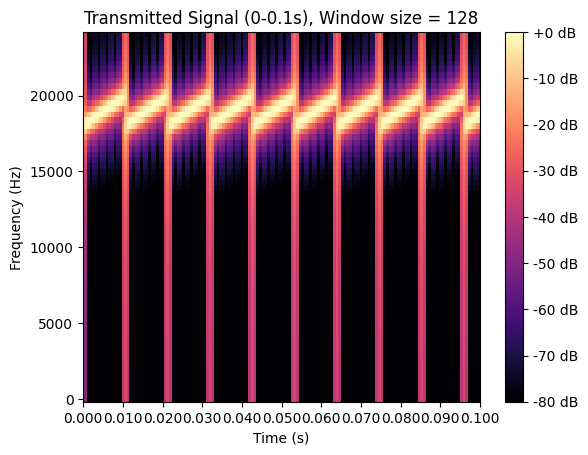

In [14]:
plot_spectogram(transmitted, sampling_rate, title="Transmitted Signal (0-0.1s), Window size = 128")
plt.xlim(0,0.1)

##### **Ideal Multiplied (without Tone) Signal**

In [15]:
if transmitted.shape[0] < received_chirp.shape[0]:
    received_chirp1 = received_chirp[:transmitted.shape[0]]
    transmitted1 = transmitted

else:
    transmitted1 = transmitted[:received_chirp.shape[0]]
    received_chirp1 = received_chirp

mix = transmitted1 * received_chirp1

In [16]:
F_mix,A_mix = compute_fft(mix, sampling_rate)

print("Resolution: ", 24000/len(F_mix))

all_F_mix = [F_mix[np.where(A_mix == np.sort(A_mix)[::-1][i])] for i in range(10)]
print("Mixed Signal (Chirp) frequencies: ")
all_F_mix

Resolution:  0.03333333333333333
Mixed Signal (Chirp) frequencies: 


[array([11275.63333333]),
 array([25.63333333]),
 array([9963.13333333]),
 array([1338.13333333]),
 array([10338.13333333]),
 array([400.63333333]),
 array([10900.63333333]),
 array([31.56666667]),
 array([8780.93333333]),
 array([963.13333333])]

Text(0.5, 1.0, 'Ideal Mixed Signal (Without Tone) Spectrogram')

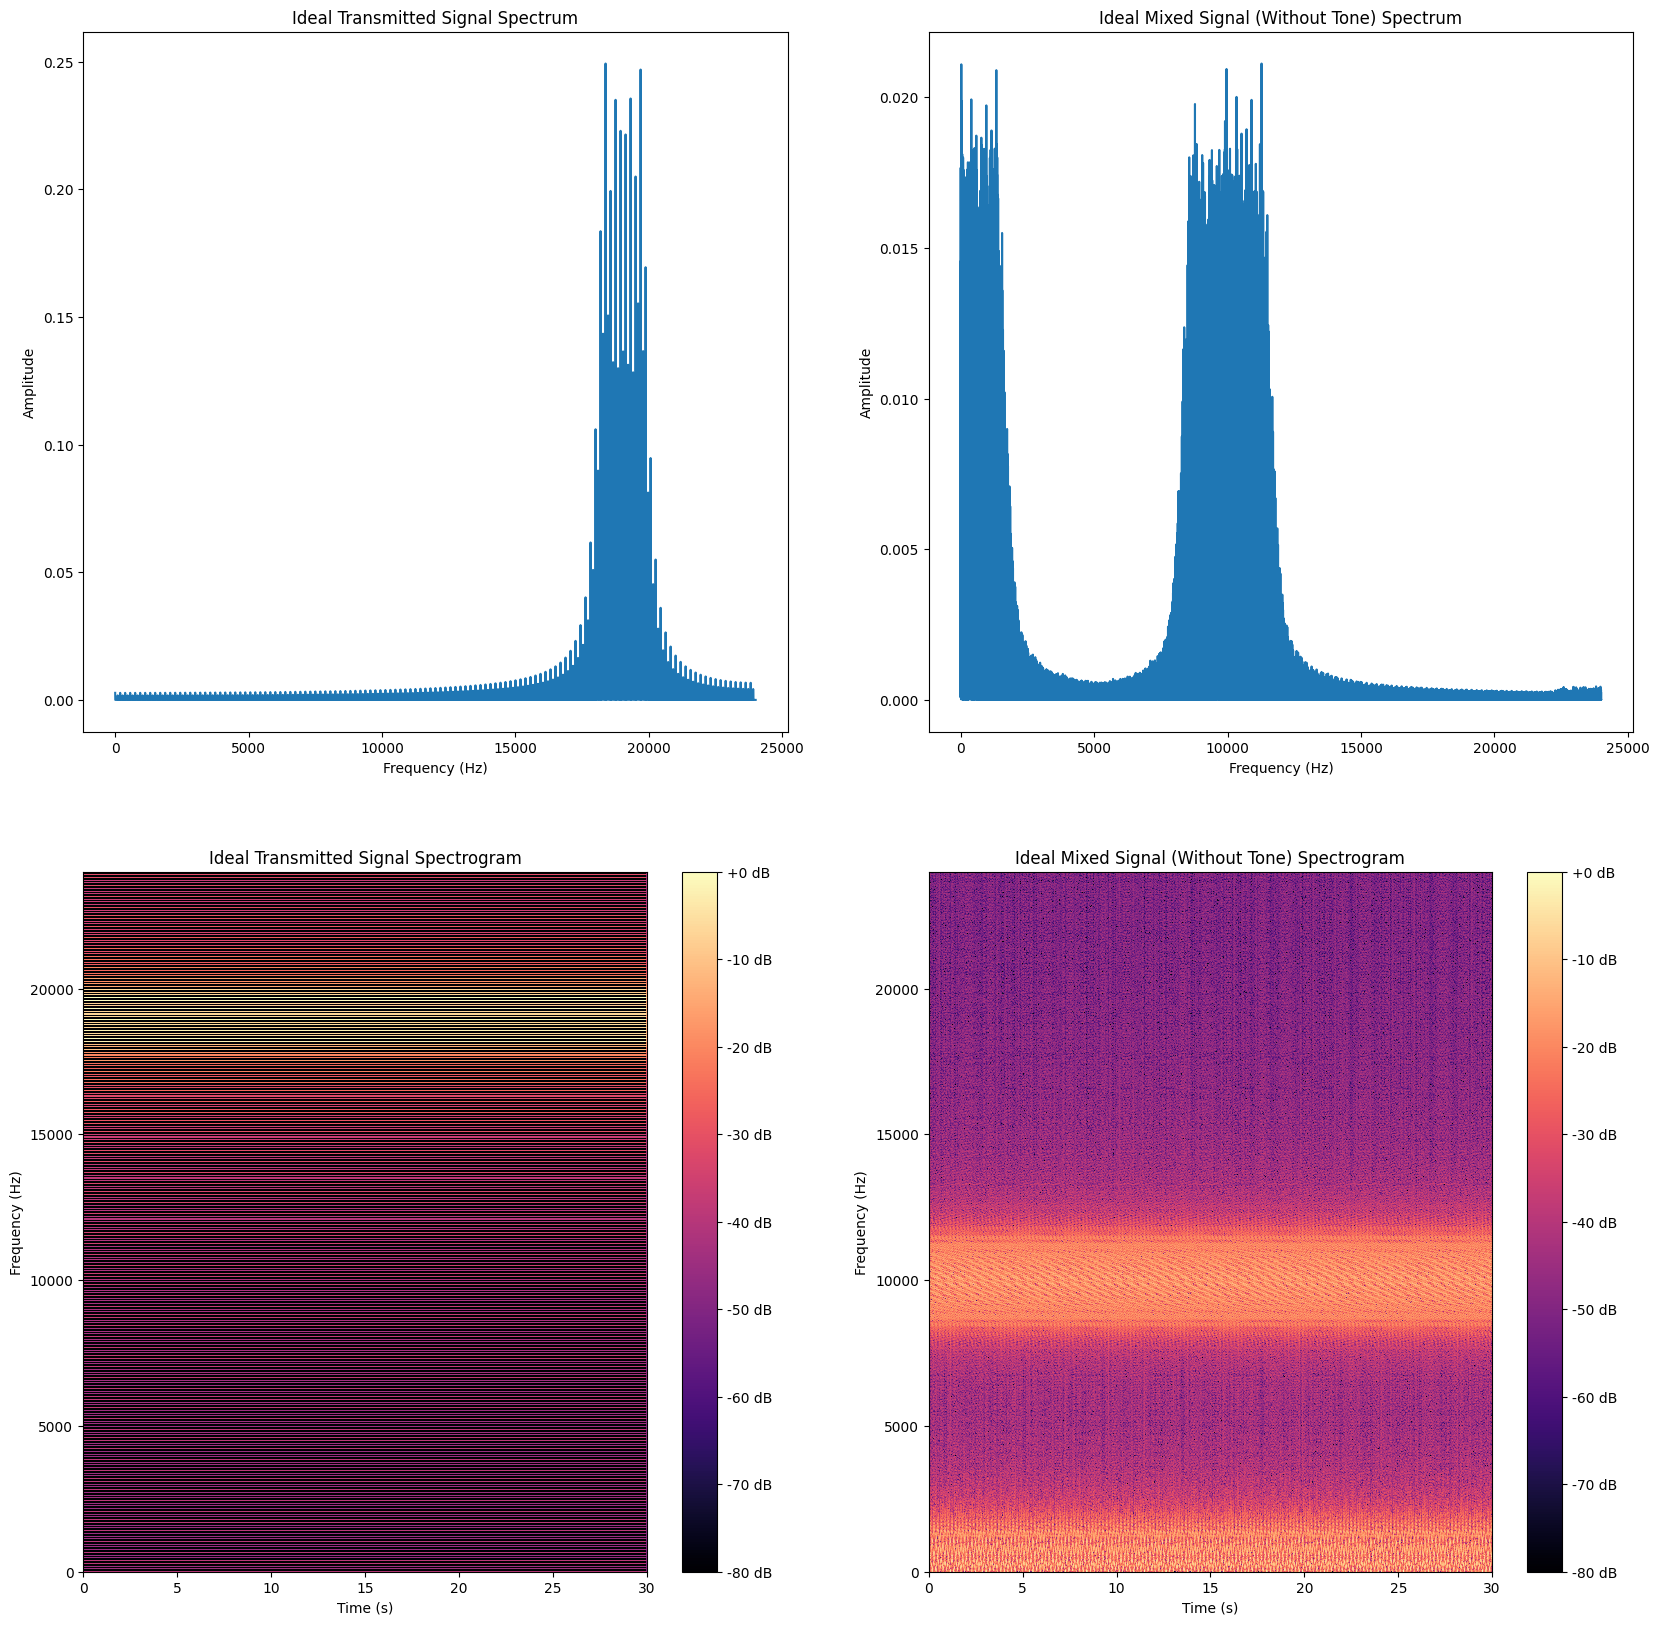

In [17]:
fig2, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (20,20))

ax1.plot(F_transmitted, A_transmitted)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Ideal Transmitted Signal Spectrum')

ax2.plot(F_mix, A_mix)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Ideal Mixed Signal (Without Tone) Spectrum')

plot_spectogram(transmitted, sampling_rate, n_fft= 4096, ax=ax3)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')
ax3.set_title('Ideal Transmitted Signal Spectrogram')

plot_spectogram(mix, sampling_rate, n_fft= 4096, ax=ax4)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Frequency (Hz)')
ax4.set_title('Ideal Mixed Signal (Without Tone) Spectrogram')

##### **Tone of 0.5Hz**

In [18]:
def generateAudio(freq, sr, dur, samples=None):
    '''
    Generates a tone (continuous wave)

    Parameters:
    freq (float): frequency of the tone
    sr (num): sampling rate
    dur (num): time duration of tone
    '''
    if samples == None:
        samples = int(sr * dur)
    time = np.linspace(0, dur, samples, False)

    tone = np.sin(2 * np.pi * freq * time)  
    return tone

In [19]:
tone = generateAudio(0.5, sampling_rate, dur = 30, samples = 1440000)

print(tone.shape[0])
signal_info(tone, sampling_rate)

1440000
Sampling Rate: 48000
Signal time duration:  30.0
Number of samples:  1440000


In [20]:
F_tone, A_tone = compute_fft(tone, sampling_rate)

print("Resolution: ", 24000/len(F_tone))

all_F_tone = [F_tone[np.where(A_tone == np.sort(A_tone)[::-1][i])] for i in range(10)]
print("Mixed Signal (Chirp) frequencies: ")
all_F_tone

Resolution:  0.03333333333333333
Mixed Signal (Chirp) frequencies: 


[array([0.5]),
 array([0.53333333]),
 array([0.46666667]),
 array([9343.5]),
 array([9344.5]),
 array([9344.53333333]),
 array([9343.53333333]),
 array([15766.73333333]),
 array([15767.73333333]),
 array([15767.76666667])]

(0.0, 3.0)

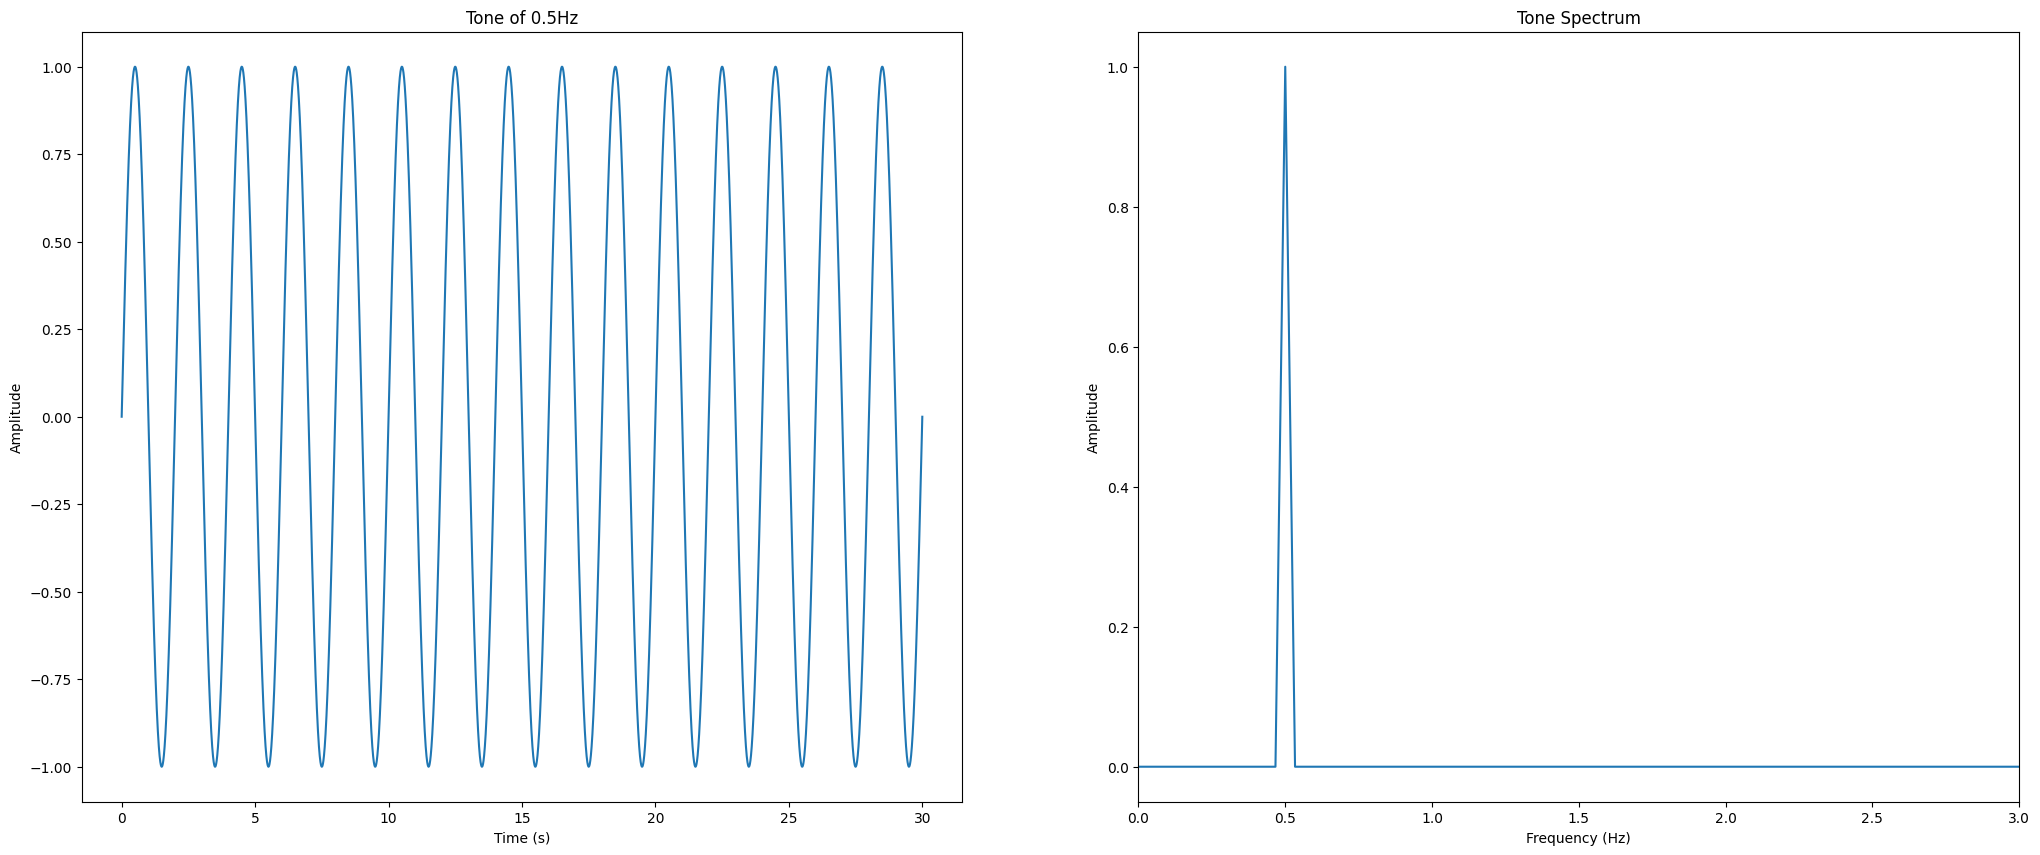

In [21]:
fig3, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize = (25,10))

ax1.plot([i/sampling_rate for i in range(len(tone))], tone)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")
ax1.set_title("Tone of 0.5Hz")

ax2.plot(F_tone, A_tone)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Tone Spectrum')
ax2.set_xlim(0,3)

##### **Ideal Received Signal (with Tone)**

In [22]:
chirp_tone_received = tone + received_chirp
signal_info(chirp_tone_received, sampling_rate)

Sampling Rate: 48000
Signal time duration:  30.0
Number of samples:  1440000


In [23]:
F_chirp_tone_received, A_chirp_tone_received = compute_fft(chirp_tone_received, sampling_rate)

print("Resolution: ", 24000/len(F_tone))

all_F_chirp_tone_received = [F_chirp_tone_received[np.where(A_chirp_tone_received == np.sort(A_chirp_tone_received)[::-1][i])] for i in range(10)]
print("chirp_tone_received Signal (Chirp) frequencies: ")
all_F_chirp_tone_received

Resolution:  0.03333333333333333
chirp_tone_received Signal (Chirp) frequencies: 


[array([0.5]),
 array([18349.36666667]),
 array([18410.13333333]),
 array([18896.2]),
 array([19260.76666667]),
 array([19746.83333333]),
 array([18713.93333333]),
 array([19564.56666667]),
 array([19686.06666667]),
 array([18956.96666667])]

Text(0.5, 1.0, 'Ideal Received Signal (With Tone) Spectrogram')

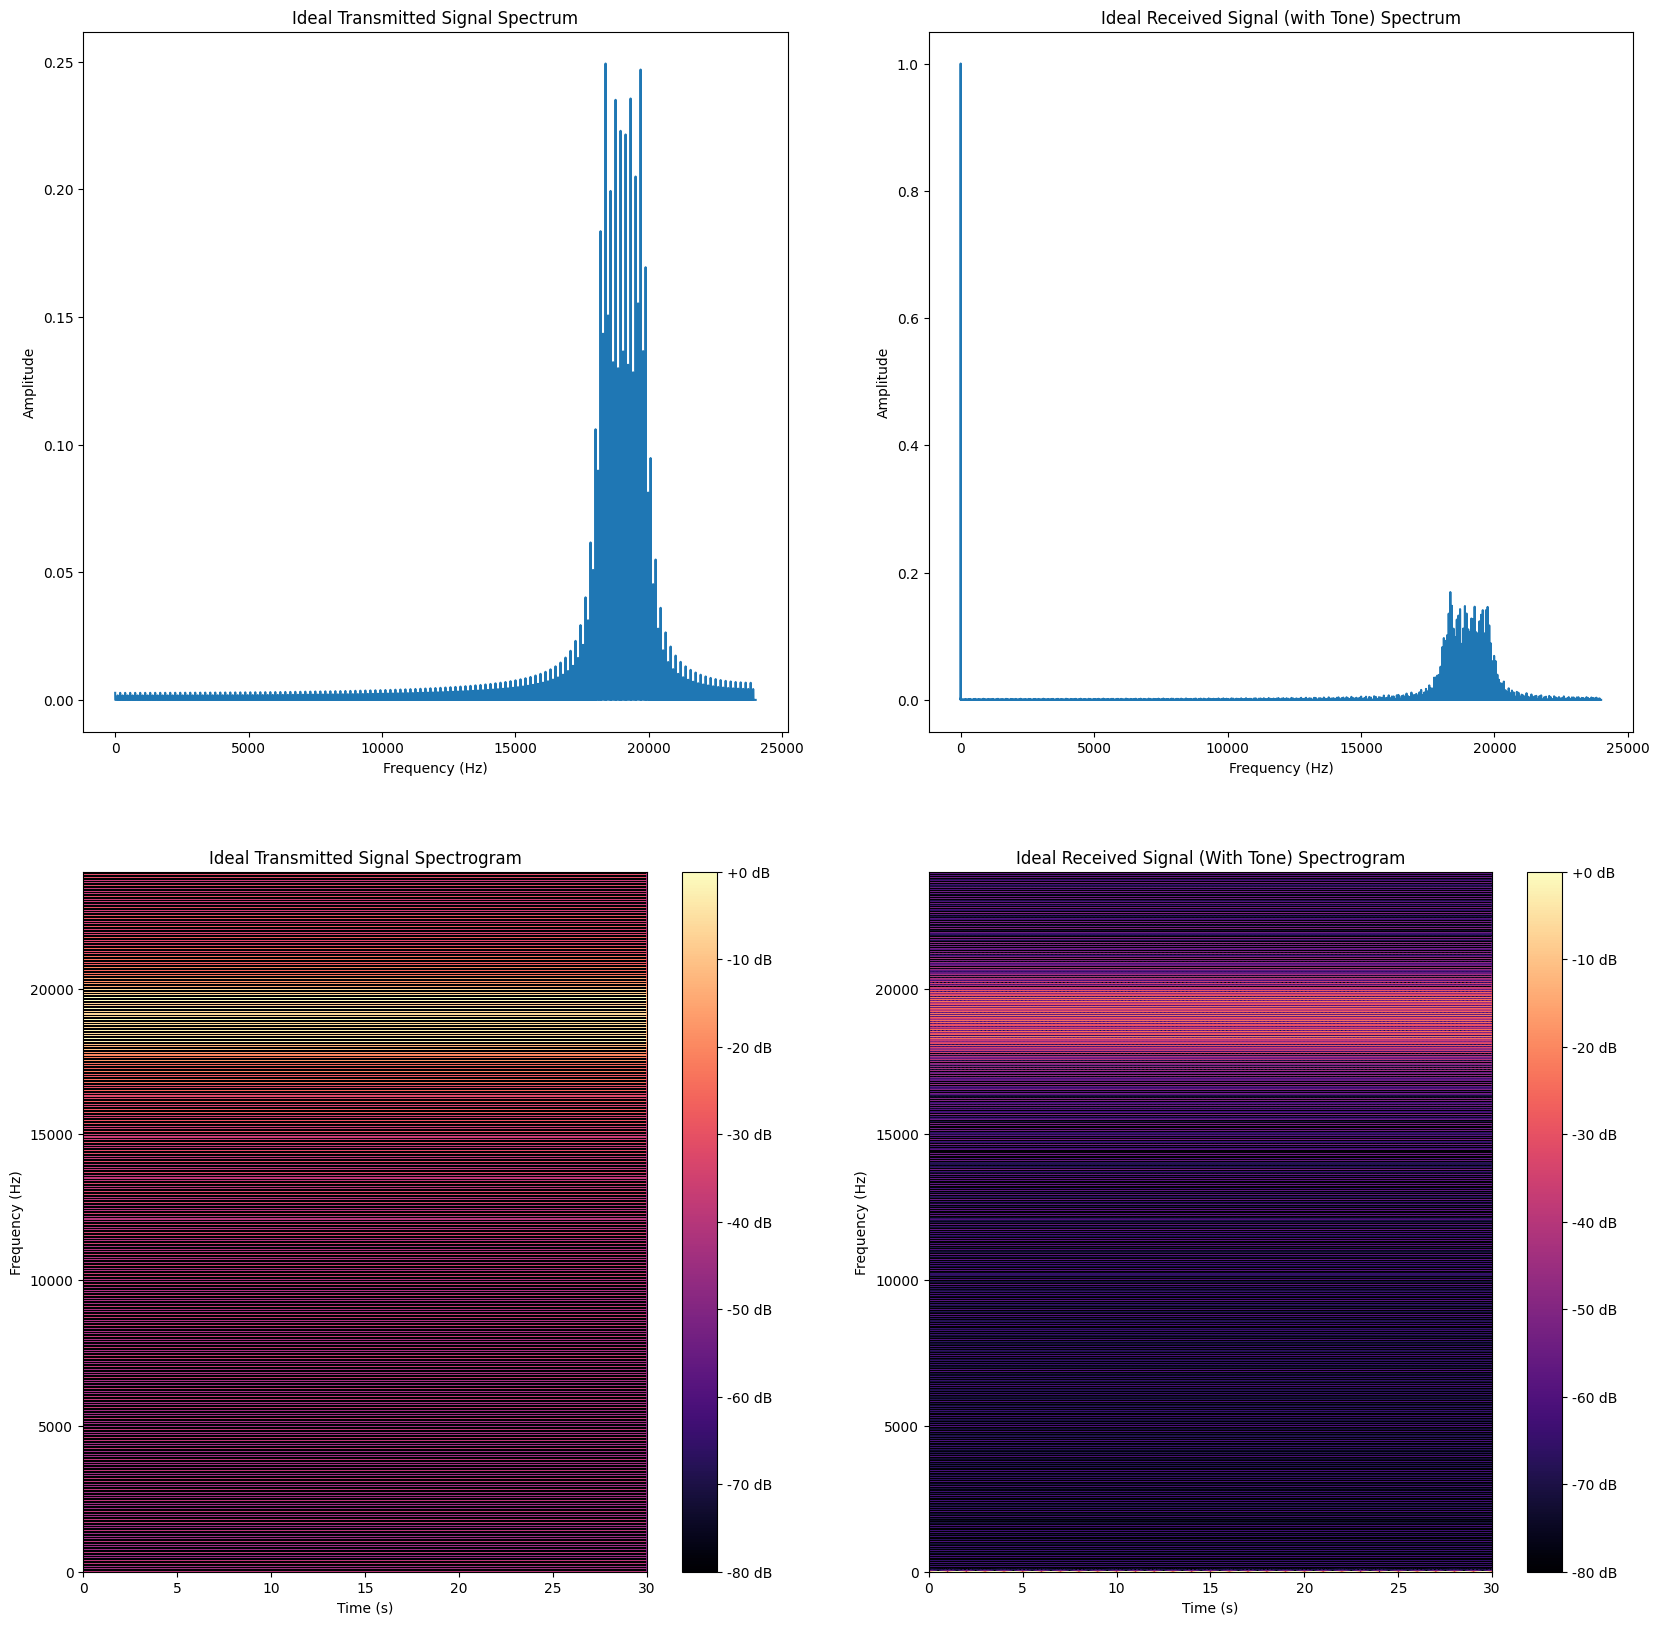

In [24]:
fig4, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (20,20))

ax1.plot(F_transmitted, A_transmitted)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Ideal Transmitted Signal Spectrum')

ax2.plot(F_chirp_tone_received, A_chirp_tone_received)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Ideal Received Signal (with Tone) Spectrum')
#ax2.set_xlim(0,2)

plot_spectogram(transmitted, sampling_rate, n_fft= 4096, ax=ax3)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')
ax3.set_title('Ideal Transmitted Signal Spectrogram')

plot_spectogram(chirp_tone_received, sampling_rate, n_fft= 4096, ax=ax4)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Frequency (Hz)')
ax4.set_title('Ideal Received Signal (With Tone) Spectrogram')

##### **Ideal Multiplied (with Tone) Signal**

In [25]:
if transmitted.shape[0] < chirp_tone_received.shape[0]:
    chirp_tone_received1 = chirp_tone_received[:transmitted.shape[0]]
    transmitted2 = transmitted

else:
    transmitted2 = transmitted[:chirp_tone_received.shape[0]]
    chirp_tone_received1 = chirp_tone_received

mix_with_tone = transmitted2 * chirp_tone_received1

In [26]:
F_mix_with_tone, A_mix_with_tone = compute_fft(mix_with_tone, sampling_rate)

print("Resolution: ", 24000/len(F_mix_with_tone))

all_F_mix_with_tone = [F_mix_with_tone[np.where(A_mix_with_tone == np.sort(A_mix_with_tone)[::-1][i])] for i in range(10)]
print("Mixed Signal (with Tone) frequencies: ")
all_F_mix_with_tone

Resolution:  0.03333333333333333
Mixed Signal (with Tone) frequencies: 


[array([18375.5]),
 array([18374.5]),
 array([19688.]),
 array([19687.]),
 array([19313.]),
 array([19312.]),
 array([18750.5]),
 array([18749.5]),
 array([18938.]),
 array([18937.])]

Text(0.5, 1.0, 'Ideal Mixed Signal (With Tone) Spectrogram')

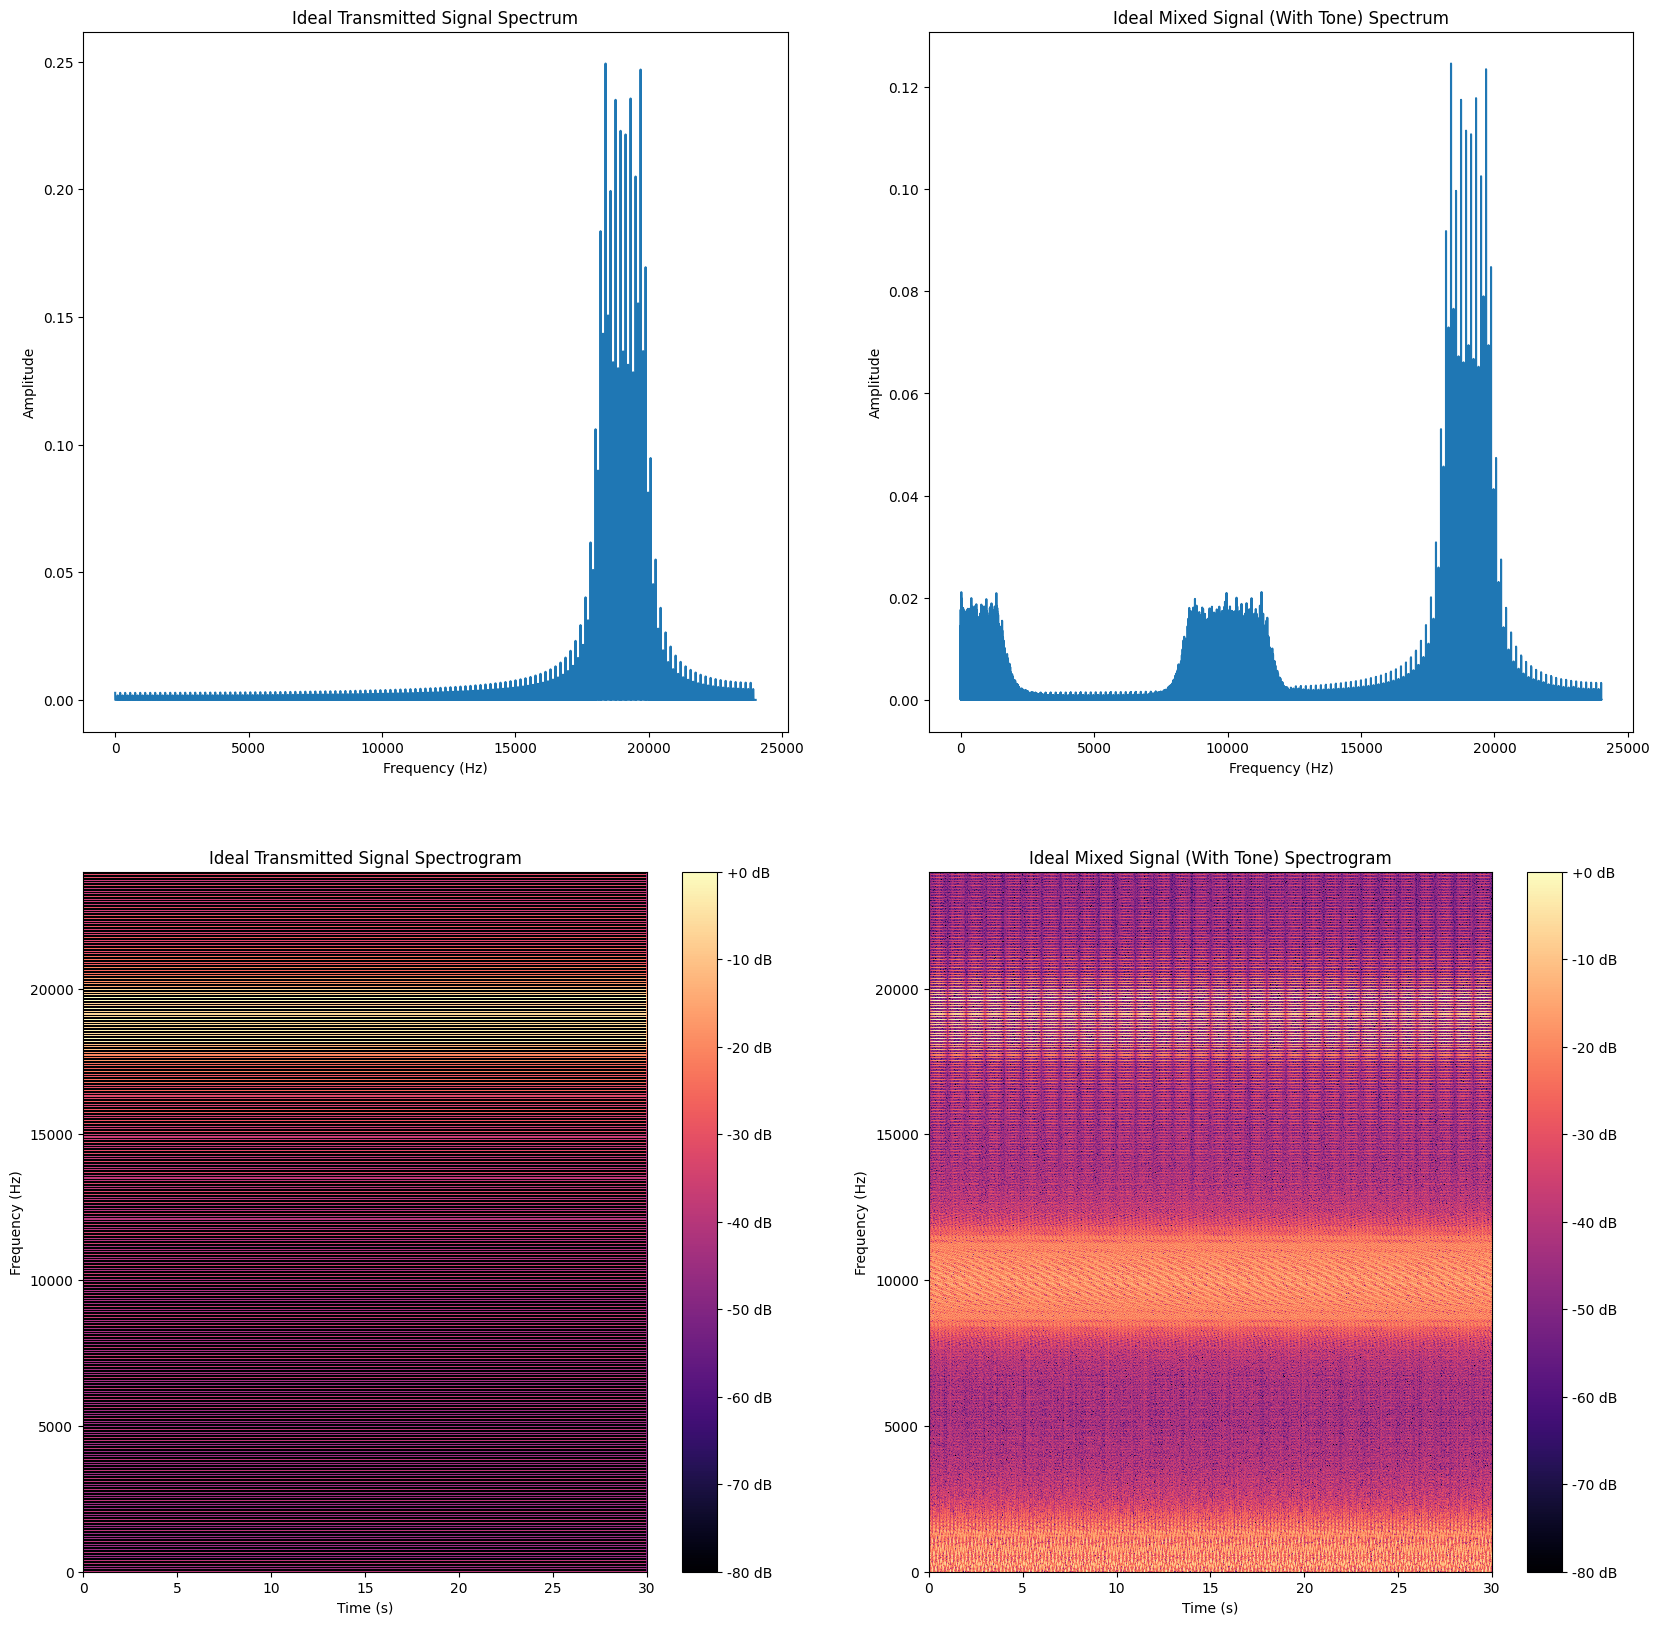

In [27]:
fig5, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (20,20))

ax1.plot(F_transmitted, A_transmitted)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Ideal Transmitted Signal Spectrum')

ax2.plot(F_mix_with_tone, A_mix_with_tone)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Ideal Mixed Signal (With Tone) Spectrum')

plot_spectogram(transmitted, sampling_rate, n_fft= 4096, ax=ax3)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')
ax3.set_title('Ideal Transmitted Signal Spectrogram')

plot_spectogram(mix_with_tone, sampling_rate, n_fft= 4096, ax=ax4)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Frequency (Hz)')
ax4.set_title('Ideal Mixed Signal (With Tone) Spectrogram')